*Note: To reduce model complexity and notebook length, several simplifying assumptions were made during the analysis below. Please refer to the "Assumptions" section at the end for more information.*

Continuing from the overview of transformer prognostics in Part 1, a transformer simulation model was developed in this notebook to generate dissolved gas accumulations in a simulated transformer. Several academic papers were used to estimate the rate of insulation degradation and dissolved gas accumulation according to several environmental factors, including ambient temperature.

The transformer simulation contains three primary modules:

* Core hot spot
* Paper insulation degradation
* Oil contamination

The following sections will go into more detail about each of these three modules.

### Core Hot Spot

Recall from Part 1 that the degree to which paper insulation is degraded depends on the stress it receives from ambient heat. The "core hot spot" temperature of a transformer is the hottest temperature generated by the windings, and it represents the "weakest link" of the paper insulation. The simulation will only consider the probability that the part of the paper insulation closest to the core hot spot will tear, since it is at the point of highest stress.

The core hot spot temperature is not usually measured directly, but it can be inferred from the ambient temperature using empirical relationships. The equation used for this simulation is described in the paper "Loading Transformers By Temperature" [Montsinger]:

[IMAGE IN BLOG POST]

Where T is the total core hot spot temperature, T0 is the temperature rise over the ambient oil temperature, N is the copper to iron loss ratio, R is the ratio of the overload to the rated load, Tc is the temperature rise of the windings over the oil, and L is a known constant. All temperatures are in Celsius.

The following function will calculate the core hot spot temperature based on the above equation, taking the ambient temperature and overload ratio as required inputs. Many of the quantities in the above equation depend on the physical features of the oil and transformer; default values for a typical transformer were selected for simplification, or else the parameters were held constant.

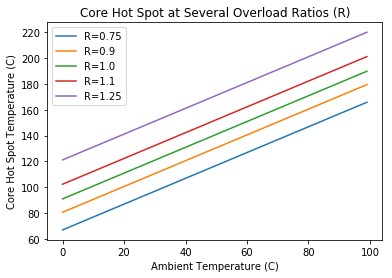

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Calculates the core hot spot temperature of the transformer
def core_hot_spot(ambient_temp, overload_ratio, t0=35, tc=30, N=1, 
                N0=0.5, Nc=0.8, L=1):
    # ambient_temp is in Celsius
    # overload_ratio is in decimal form (e.g. 0.75 not 75%)
    # t0 is the temperature rise of oil over ambient
    # tc is the temperature rise of the windings over the oil
    # N = 1 (for simplification only)
    # N0 = 0.8 for self-cooled transformers, =0.5 for water-cooled
    # Nc = 1.0 for vertical windings, =0.8 for horizontal windings
    # L = 1 (for simplification only)
    T = t0*((N*overload_ratio**2+1)**0.8) + tc*L*overload_ratio**2 + ambient_temp
    return T

# Plot the core hot spot as ambient temperature increases
for R in [0.75, 0.9, 1.0, 1.1, 1.25]:
    # Use a listcomp to generate the core hot spots
    plt.plot([core_hot_spot(ii, R) for ii in range(100)])
# Plot labels
plt.legend(['R=0.75', 'R=0.9', 'R=1.0', 'R=1.1', 'R=1.25'])
plt.xlabel('Ambient Temperature (C)')
plt.ylabel('Core Hot Spot Temperature (C)')
plt.title('Core Hot Spot at Several Overload Ratios (R)');

The figure above demonstrates the core hot spot temperature from 0 to 100 degrees C, for five different overload ratios. Notice that the relationship between ambient temperature and core hot spot temperature (for all overload ratios) is linear. Examine Montsinger's equation (as well as the simplifying assumptions mentioned in the code above) to determine why this is the case.

When a transformer is sufficiently degraded, it may be operated at much lower loads than its rated load, a process called derating. Since derating reduces the core hot spot temperature, the amount of stress placed on the paper insulation will also be reduced, increasing its lifetime.

### Paper Insulation Degradation

The degree of polymerization (DP) of the paper insulation is one of the best indicators of its tensile strength. When first manufactured, the DP of paper insulation will typically be between 1000 and 1300. At paper insulation failure, its DP is reduced to about 20% of its starting value, and DP below 150 is almost guaranteed to fail immediately.

The general law of paper insulation degradation over time is given by [Emsley]:

[IMAGE IN BLOG POST]

Where k is a constant that depends on the core hot spot temperature and physical characteristics of the transformer, t is the time in hours, DPf is the degree of polymerization of the paper after *t* hours, and DPi is the initial DP of the paper before *t* hours.

The following function will calculate the change in DP of the paper insulation due to heat stresses from the core hot spot temperature. As in the previous model, the calculation of k was simplified to decrease model complexity. (For more information, please refer to Emsley's paper directly.)


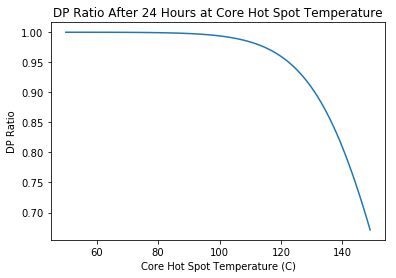

In [7]:
def calculate_dp(core_hot_spot, time, dp_initial):
    # core_hot_spot is an output from the previous function
    # time is measured in hours
    # dp_initial is the initial degree of polymerization
    # A is a constant based on the type of paper insulation
    # k calculation is taken from [Emsley]
    A = 3.65*10**7
    # See Emsley's paper for more discussion of this equation
    k = A*np.exp(-(117000/(8.314*(core_hot_spot+273.15))))
    DPf=1/((k*24*7*time) + (1/dp_initial))
    return DPf
    
# Plot the DP ratio as a function of core hot spot for 1 day
dp_ratio = [calculate_dp(chs, 24, 1000)/1000 for chs in range(50, 150)]
plt.plot(range(50, 150), dp_ratio)
plt.xlabel('Core Hot Spot Temperature (C)')
plt.ylabel('DP Ratio')
plt.title('DP Ratio After 24 Hours at Core Hot Spot Temperature');

The figure above plots the ratio of initial DP (assumed to be starting at 1000) to final DP after 24 hours at a particular core hot spot temperature. Notice that below about 80 degrees C there is very little change, but after 110 degrees C the ratio drops off sharply. This behavior is the reason for derating; as the overload ratio of the transformer decreases, its core hot spot temperature will also decrease, which reduces the amount of degradation the paper insulation will experience.

### Oil Contamination

As mentioned in Part 1 of this topic, damage to the paper insulation will release dissolved gas byproducts (such as hydrogen, carbon monoxide, and carbon dioxide) in the insulating oil. These dissolved gases are condition indicators, correlated with the amount of degradation that the paper insulation has experienced.

For the oil contamination module, several papers were used to simulate the accumulation of carbon monoxide and carbon dioxide in a transformer based on paper insulation DP. Unfortunately, academic papers describing this relationship are limited, and power companies are very protective of their DGA data. Hence, measurements from a paper by [Pradhan and Ramu] were used to create a linear relationship between DP and carbon monoxide/dioxide.

While this relationship may not be entirely accurate, it is good enough for the purposes of this simulation. To account for the random variation in the paper's data, normally-distributed noise was added in this module based on the standard deviation of the empirical data.

*(Note that this situation is also commonly modeled using chemical equations as a "physics-of-failure" model. Paper insulation is an organic compound, and its breakdown should result in hydrogen and carbon compounds, etc.)*

The equations developed from empirical data in Pradhan and Ramu's paper are:

[IMAGE IN BLOG POST]

The following code will implement these equations within the oil contamination module. Note that the CO and CO2 values that this function returns are the **total** accumulation of these dissolved gases over time; it is not the current rate of accumulation.

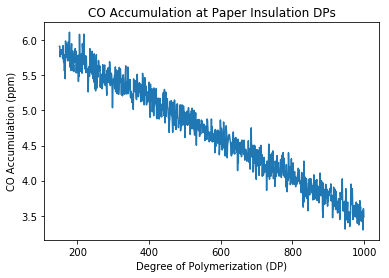

In [12]:
def oil_contamination(dp):
    # dp is the degree of polymerization
    # CO and CO2 are the TOTAL accumulation
    # of each of those dissolved gases
    CO=(-0.0028*dp + 6.28) + 0.13*np.random.randn()
    CO2=(-0.0026*dp + 8.08) + 0.66*np.random.randn()
    return CO, CO2

# Plot the CO as a function of DP over time
co_accumulation = [oil_contamination(dp)[0] for dp in range(150, 1000)]
plt.plot(range(150, 1000), co_accumulation)
plt.xlabel('Degree of Polymerization (DP)')
plt.ylabel('CO Accumulation (ppm)')
plt.title('CO Accumulation at Paper Insulation DPs');

As expected, when the DP of the paper insulation is low (due to damage from heat stresses), the CO accumulation is high (due to byproducts from the degradation process).

### Transformer Simulation Overview

The following figure demonstrates the basic "flow" of the simulation:

[IMAGE IN BLOG POST]

First, the ambient temperature will be estimated based on the current month and the monthly lows, averages, and highs specified by the user. Per day, it is assumed that the transformer experiences 6 hours at the low temperature, 12 hours at the average temperature, and 6 hours at the high temperature.

Next, the core hot spot temperature, paper insulation damage. and oil contamination is calculated. The core hot spot temperature requires the ambient temperature and overload ratio as inputs. The paper insulation degradation module will use the core hot spot temperature to assess the damage to the paper insulation. The oil contamination module will take the current DP of the paper insulation and find the total accumulated CO and CO2.

Finally, the simulation must assess whether the paper insulation of the transformer has failed or not. Rather than set a “hard” threshold at 150 DP (as recommended by Emsley), the simulation was designed to give the paper insulation a probability to fail at values between 150 DP and 250 DP, resulting in a “soft” distribution of failures.

The following code implements the process described above.

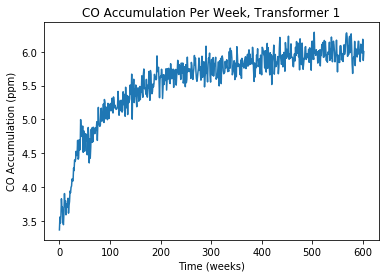

In [17]:
# Transformer INSULation SIMulator
# temps is an array of size 12x3, containing monthly low, average, and high temps
# start_month is an integer, with January = 1, February = 2, etc.
# num_transformers are the number of transformers to simulate (e.g. 20)
# overload_ratio is R in the equation above (suggest between 0.75 and 1.1)
def tinsul_sim(temps, start_month, num_transformers, overload_ratio = 1):
    trans_co = []
    trans_co2 = []
    # Iterate over the number of transformers:
    for ii in range(num_transformers):
        month_current = start_month 
        failed = False
        dp_current = 1000
        co_accumulation = []
        co2_accumulation = []
        # dp_failed determines the DP at which the paper insulation will
        # fail, drawn from a logistic distribution centered at 200
        dp_failed = np.random.logistic(loc=200.0, scale=40.0)
        # Run the simulation until the transformer fails
        while not failed:   
            # Remember- 6 hours at low, 12 hours at avg, and 6 hours at high temps
            # The first index is temp, the second index is hours at that temp
            ambient_low = [temps[int(month_current)-1][0], 6]
            ambient_avg = [temps[int(month_current)-1][1], 12]
            ambient_high = [temps[int(month_current)-1][2], 6]
            # Update DP based on the heat stresses from the core hot spot       
            for ambient, time in [ambient_low, ambient_avg, ambient_high]:
                chs = core_hot_spot(ambient, overload_ratio)
                dp_current = calculate_dp(chs, time, dp_current)
            # Calculate the CO and CO2 accumulation based on DP
            co, co2 = oil_contamination(dp_current)
            co_accumulation.append(co)
            co2_accumulation.append(co2)
            # Check if the transformer has failed, using a "soft" distribution
            if dp_current<=dp_failed:
                failed = True
            # Add the value (Months/Weeks) to get proportion of month per week 
            month_current += 0.230769
            # Rollover to the next year, if necessary
            if month_current >= 13.0:
                month_current = 1
        trans_co.append(co_accumulation)
        trans_co2.append(co2_accumulation)
    return trans_co, trans_co2

# Average temperature per month (Washington DC)
# The array is ordered: [low, average, high]
dc_temps = [[-2, 1, 6], # January
           [-1, 3, 8], # February
           [3, 7, 13], # March
           [8, 13, 19], # April
           [14, 18, 24], # May
           [19, 24, 29], # June
           [22, 28, 31], # July
           [21, 27, 30], # August
           [17, 22, 26], # September
           [10, 15, 20], # October
           [5, 10, 14], # November
           [0, 4, 8]] # December
# Use the function above to simulate transformers
transformers = tinsul_sim(dc_temps, 1, 20)   

# Plot the results from the first transformer
plt.plot(transformers[0][0])
plt.xlabel('Time (weeks)')
plt.ylabel('CO Accumulation (ppm)')
plt.title('CO Accumulation Per Week, Transformer 1');

The above figure shows the CO accumulation per week for the first simulated transformer. Notice that the curve is not linear; at the end of life, the CO accumulation rate slows down. Intuitively, this phenomena occurs because as the DP of the paper insulation is reduced, there is less insulation available to release byproducts from further breakdown.

To summarize this notebook, the inputs to the transformer insulation simulator are:

* Average temperatures per month
* Starting month (to begin the simulation)
* Number of transformers to simulate
* Overload ratio

The output values are:

* CO generation per week
* CO2 generation per week

The assumptions of the simulation include:

* No maintenance was performed on the simulated transformer throughout its lifetime, including oil reclamation.
* Montsinger's core hot spot temperature equation is an accurate approximation.
* The generic constants used in Montsinger's and Emsley's equations are applicable for a generic transformer.
* The only failure mode affecting the simulated transformer is degraded paper insulation.
* Carbon monoxide and carbon dioxide accumulations alone are good predictors of paper insulation failure. (In practice, additional dissolved gases would be incorporated into the prognostics model).
* The data from Pradhan and Ramu is sufficient to estimate the relationship between DP and carbon monoxide/dioxide accumulation.

### References

* Montsinger, V. M. "Loading Transformers By Temperature." AIEE Transactions 49 (1930): 776-79.

* Emsley, A. M., and G. C. Stevens. "Review of Chemical Indicators of Degradation of Cellulosic Electrical Paper Insulation in Oil-Filled Transformers." IEE Proc.-Sci. Meas. Technol.141.5 (1994).

* Pradhan, M. K., and T. S. Ramu. "On the Estimation of Elapsed Life of Oil-Immersed Power Transformers." IEEE Transactions on Power Delivery 20.3 (2005).